DataSet : https://www.kaggle.com/alxmamaev/flowers-recognition

In [ ]:
!unzip "/content/drive/MyDrive/FlowersRecognisation_Project/archive (1).zip" -d "/content/drive/MyDrive/FlowersRecognisation_Project"

## Checking the dataset and all the available folders inside it .

In [ ]:
data_dir = '/content/drive/MyDrive/FlowersRecognisation_Project/flowers'

import os

os.listdir(data_dir)

['daisy', 'dandelion', 'flowers', 'rose', 'sunflower', 'tulip']

In [ ]:
# Remove the extra flowers folder which some how came up
import shutil

shutil.rmtree(data_dir + '/flowers')

In [ ]:
# Now we have all the right categories 

print("Labels => ",os.listdir(data_dir))

# No. of images in each labels 

print("\nNo. of images in each labels => ")
for cls in os.listdir(data_dir):
  print([cls, ":" , len(os.listdir(data_dir+ '/' + cls))])

Labels =>  ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

No. of images in each labels => 
['daisy', ':', 769]
['dandelion', ':', 1055]
['rose', ':', 784]
['sunflower', ':', 734]
['tulip', ':', 984]


## Import the dataset into PyTorch

Use the `ImageFolder` class from `torchvision` 

In [ ]:
from torchvision.datasets import ImageFolder

dataset = ImageFolder(data_dir)   # Pointed the ImageFolder to all the sub folders (Categories)
print("Dataset Length: ", len(dataset))
print("Classes: ",dataset.classes)
print("A Perticular Element: ",dataset[0])

Dataset Length:  4323
Classes:  ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']
A Perticular Element:  (<PIL.Image.Image image mode=RGB size=320x263 at 0x7F9200FCD240>, 0)


Visualizing an Image

Label:  0


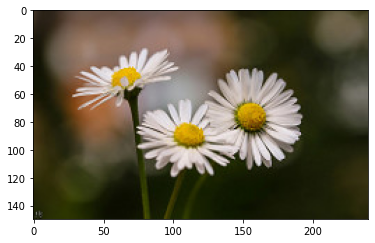

In [ ]:
import matplotlib.pyplot as plt
img,label = dataset[400]
print("Label: ",label)
plt.imshow(img);  # Looking at the first image 

Transforming the images

> About `Compose` Function : https://pytorch.org/docs/stable/torchvision/transforms.html

In [ ]:
import torchvision.transforms as tt

dataset = ImageFolder(data_dir , 
                      tt.Compose([tt.Resize(64), 
                                  tt.RandomCrop(64),
                                  tt.ToTensor()]))

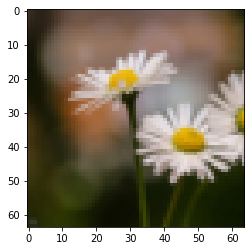

In [ ]:
# The tronsformed deminsions are [3,224,224] 
# Conver them into ~ [224,224,3]
img , label = dataset[400]
plt.imshow(img.permute((1,2,0)))

Split the data into train and val using random_split method

> About `random_split` method :
 https://pytorch.org/docs/stable/data.html

In [ ]:
val_per = 0.1
val_size = int(val_per * len(dataset))
train_size = len(dataset) - val_size

from torch.utils.data import random_split
                                  #Data        #Size
train_ds,valid_ds = random_split(dataset, [train_size,val_size])

print("Train Size: ",len(train_ds) ," |  Validation Size: ",len(valid_ds) )

Train Size:  3891  |  Validation Size:  432


Create a dataloader to load a batch of images into our model

In [ ]:
from torch.utils.data.dataloader import DataLoader

batch_size=64

train_dl = DataLoader(train_ds, 
                      batch_size, 
                      shuffle=True, 
                      num_workers=4, 
                      pin_memory=True)

valid_dl = DataLoader(valid_ds, 
                    batch_size, 
                    num_workers=4, 
                    pin_memory=True)

Display a batch of Images

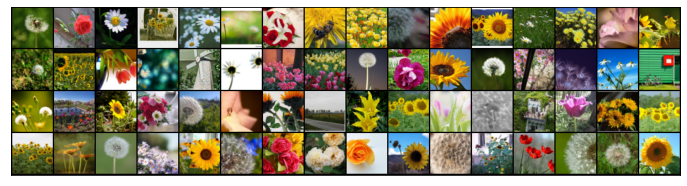

In [ ]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

show_batch(train_dl)

## GPU Utilities

In [ ]:
# Move our model and data to GPU

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
# Chech for GPU availablity

import torch
print("Check for GPU Availability: ",torch.cuda.is_available())

device = get_default_device()
device

Check for GPU Availability:  True


device(type='cuda')

In [ ]:
# Image sample 

img,label = dataset[0]

print("Default device - CPU: ",img.device)

img_gpu = to_device(img,device)
print("Moved to - GPU: ",img_gpu.device)

Default device - CPU:  cpu
Moved to - GPU:  cuda:0


In [ ]:
# Whenever the batches are requested those batches are ove the GPU

train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

## Model and Training Utilities

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

## Model

In [ ]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        
        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        
        self.classifier = nn.Sequential(nn.AdaptiveAvgPool2d(1), 
                                        nn.Flatten(), 
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

model = to_device(ResNet9(3, len(dataset.classes)), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [ ]:
# Pass one batch of input tensor through the model
torch.cuda.empty_cache()
for batch in train_dl:
  images, labels = batch
  print('images.shape',images.shape)
  print('images.device',images.device)
  preds = model(images)
  print('preds.shape',preds.shape)
  break

images.shape torch.Size([64, 3, 64, 64])
images.device cuda:0
preds.shape torch.Size([64, 5])


## Training

In [ ]:
history = [evaluate(model,valid_dl)]
history

[{'val_acc': 0.1629464328289032, 'val_loss': 1.6128036975860596}]

In [ ]:
history += fit(5,0.001,model,train_dl,valid_dl,torch.optim.Adam)

Epoch [0], train_loss: 1.2209, val_loss: 1.0972, val_acc: 0.5789
Epoch [1], train_loss: 0.9768, val_loss: 1.4205, val_acc: 0.5134
Epoch [2], train_loss: 0.8990, val_loss: 0.9204, val_acc: 0.6704
Epoch [3], train_loss: 0.8188, val_loss: 1.2164, val_acc: 0.5908
Epoch [4], train_loss: 0.7899, val_loss: 1.4499, val_acc: 0.5595


In [ ]:
history += fit(5,0.001,model,train_dl,valid_dl,torch.optim.Adam)

Epoch [0], train_loss: 0.7782, val_loss: 1.5218, val_acc: 0.5766
Epoch [1], train_loss: 0.7242, val_loss: 1.0569, val_acc: 0.5960
Epoch [2], train_loss: 0.6905, val_loss: 0.9231, val_acc: 0.6845
Epoch [3], train_loss: 0.6569, val_loss: 0.6921, val_acc: 0.7812
Epoch [4], train_loss: 0.6344, val_loss: 0.6477, val_acc: 0.7582


In [ ]:
history += fit(5,0.0001,model,train_dl,valid_dl,torch.optim.Adam)

Epoch [0], train_loss: 0.5117, val_loss: 0.5334, val_acc: 0.8088
Epoch [1], train_loss: 0.4911, val_loss: 0.5238, val_acc: 0.8222
Epoch [2], train_loss: 0.4705, val_loss: 0.5226, val_acc: 0.8140
Epoch [3], train_loss: 0.4534, val_loss: 0.4975, val_acc: 0.8289
Epoch [4], train_loss: 0.4347, val_loss: 0.5121, val_acc: 0.8170


In [ ]:
history += fit(5,0.0001,model,train_dl,valid_dl)

Epoch [0], train_loss: 0.4240, val_loss: 0.5060, val_acc: 0.8289
Epoch [1], train_loss: 0.4284, val_loss: 0.4964, val_acc: 0.8244
Epoch [2], train_loss: 0.4224, val_loss: 0.5087, val_acc: 0.8289
Epoch [3], train_loss: 0.4160, val_loss: 0.4917, val_acc: 0.8311
Epoch [4], train_loss: 0.4144, val_loss: 0.4939, val_acc: 0.8199


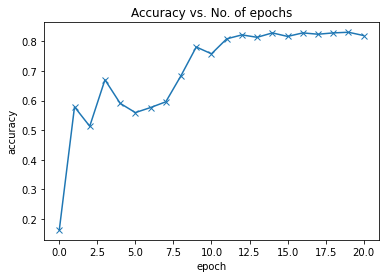

In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

plot_accuracies(history)

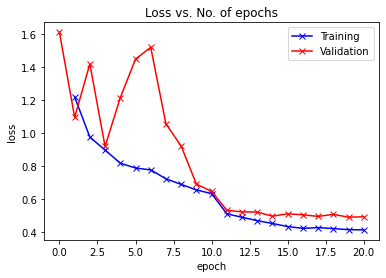

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');
    
plot_losses(history)

## Prediction

In [ ]:
def predict_image(img, model,classes):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return classes[preds[0].item()]

In [ ]:
def show_image_prediction(img,label):
  
  plt.imshow(img.permute(1,2,0))
  pred = predict_image(img,model, dataset.classes)
  print("Target: ",dataset.classes[label])
  print("Predicted: ",pred)

Target:  dandelion
Predicted:  dandelion


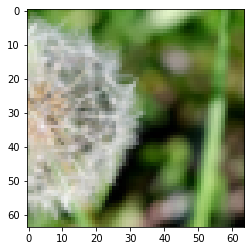

In [ ]:
show_image_prediction(*valid_ds[100])

Target:  sunflower
Predicted:  sunflower


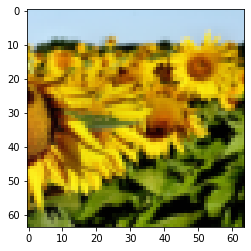

In [ ]:
show_image_prediction(*valid_ds[9])

Target:  dandelion
Predicted:  dandelion


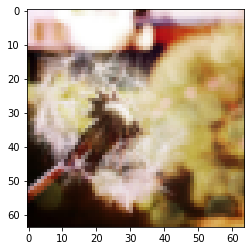

In [ ]:
show_image_prediction(*valid_ds[300])

Target:  daisy
Predicted:  sunflower


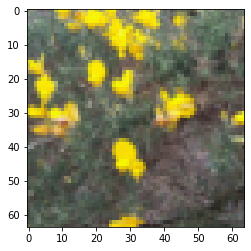

In [ ]:
show_image_prediction(*valid_ds[0])

Saving the model

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/FlowersRecognisation_Project/flowers-resnet9.pth')